# Sentiment analysis of IMDB ratings database

This notebook implements several 

In [16]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier


# Read the database

In [20]:
path = Path("datasets/movie.csv")
df = pd.read_csv(path, delimiter=",")

print(f"Number of reviews in the database: {len(df)}")
print(df.head())

X = df["text"].values
y = df["label"].values


Number of reviews in the database: 40000
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


# Preprocessing

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
pre_pipe = Pipeline(steps=[("to-bag-of-words", CountVectorizer()),
                           ("normalize", TfidfTransformer())])

X_train = pre_pipe.fit_transform(X_train)
X_test = pre_pipe.transform(X_test)

print(f"Number of features:\t{X_train.shape[1]}")

Number of features:	84719


Wow! That'a lot of features! But most of them are either unique, or ubiquitous... Let's filter some of them out!

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Remove words that appearinf with frequency < 1e-3 and > 0.8
pre_pipe = Pipeline(steps=[("normalize", TfidfVectorizer(min_df=1e-3, max_df = 0.8))])
X_train = pre_pipe.fit_transform(X_train)
X_test = pre_pipe.transform(X_test)
print(f"Number of features:\t{X_train.shape[1]}")

Number of features:	10240


# Regularisation coefficient optimization

In this section, we implement a simple MLPClassifier consisting of only 1 hidden layer and try to optimize the regulation parameter $\alpha$.

A key problem of the bag-of-word approach is that the number of features is WAY greater than the number of samples. As a consequence, the algorithm is prone to overfitting, which reduces the validation score of the test data.

In [26]:
ALPHA = np.logspace(-3, -0.5, 6)
model = []
score_test = []
score_train = []
for i, alpha in enumerate(ALPHA):
    print("="*12 + f"Step {i+1}/{len(ALPHA)}: alpha={alpha:.1e}" + "="*12)
    n_feature = X_train.shape[1]
    mlp = MLPClassifier(hidden_layer_sizes=(10), 
                        activation="relu", solver="adam", 
                        alpha=alpha, learning_rate_init=1e-3,
                        random_state=1, verbose=False, batch_size=100)
    mlp.fit(X_train, y_train)
    
    model.append(mlp)
    sc_test = mlp.score(X_test, y_test)
    sc_train = mlp.score(X_train, y_train)
    print(f"\tScore on test data:\t{sc_test}")
    print(f"\tScore on train data:\t{sc_train}")
    score_test.append(sc_test)
    score_train.append(sc_train)
    


============Step 1/6: alpha=1e-03============
	Score on test data:	0.852625
	Score on train data:	1.0
============Step 2/6: alpha=3e-03============
	Score on test data:	0.846125
	Score on train data:	0.99959375
============Step 3/6: alpha=1e-02============
	Score on test data:	0.857875
	Score on train data:	0.99653125
============Step 4/6: alpha=3e-02============
	Score on test data:	0.877625
	Score on train data:	0.97675
============Step 5/6: alpha=1e-01============
	Score on test data:	0.8925
	Score on train data:	0.94528125
============Step 6/6: alpha=3e-01============
	Score on test data:	0.887375
	Score on train data:	0.91009375


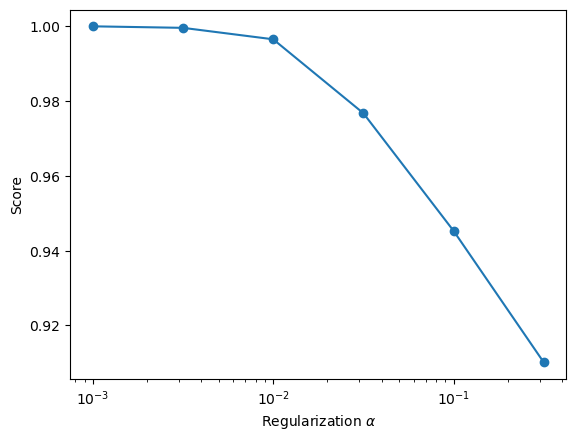

In [27]:
plt.semilogx(ALPHA, score_train,"-o")
plt.xlabel(r"Regularization $\alpha$")
plt.ylabel(r"Score")
plt.show()

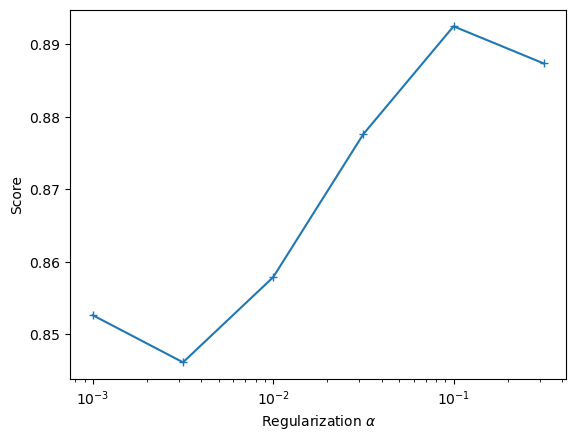

In [28]:
plt.semilogx(ALPHA, score_test,"-+")
plt.xlabel(r"Regularization $\alpha$")
plt.ylabel(r"Score")
plt.show()

# Optimization of the network architecture

Let's try other networks and see how they perform!

In [30]:
HIDDEN_LAYERS = [(50),(10),(5),(10, 10),(20, 5)]
model = []
score_test = []
score_train = []
for i, hidden_layers in enumerate(HIDDEN_LAYERS):
    print("="*12 + f"Step {i+1}/{len(HIDDEN_LAYERS)}: layer={hidden_layers}" + "="*12)
    n_feature = X_train.shape[1]
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, 
                        activation="relu", solver="adam", 
                        alpha=0.1, learning_rate_init=1e-3,
                        random_state=1, verbose=False, batch_size=100)
    mlp.fit(X_train, y_train)
    
    model.append(mlp)
    sc_test = mlp.score(X_test, y_test)
    sc_train = mlp.score(X_train, y_train)
    print(f"\tScore on test data:\t{sc_test}")
    print(f"\tScore on train data:\t{sc_train}")
    score_test.append(sc_test)
    score_train.append(sc_train)
    

============Step 1/5: layer=50============
	Score on test data:	0.88625
	Score on train data:	0.90396875
============Step 2/5: layer=10============
	Score on test data:	0.88825
	Score on train data:	0.91215625
============Step 3/5: layer=5============
	Score on test data:	0.886625
	Score on train data:	0.90909375
============Step 4/5: layer=(10, 10)============
	Score on test data:	0.887625
	Score on train data:	0.96171875
============Step 5/5: layer=(20, 5)============
	Score on test data:	0.888375
	Score on train data:	0.96215625


In [35]:
mlp = MLPClassifier(hidden_layer_sizes=(20,5), 
                    activation="relu", solver="adam", 
                    alpha=5e-1, learning_rate_init=1e-3,
                    random_state=1, verbose=False, batch_size=100)
mlp.fit(X_train, y_train)
sc_test = mlp.score(X_test, y_test)
sc_train = mlp.score(X_train, y_train)

# model.append(mlp)
# sc_test = mlp.score(X_test, y_test)
# sc_train = mlp.score(X_train, y_train)
print(f"\tScore on test data:\t{sc_test}")
print(f"\tScore on train data:\t{sc_train}")
# score_test.append(sc_test)
# score_train.append(sc_train)


	Score on test data:	0.892
	Score on train data:	0.94196875


In [39]:
mlp = MLPClassifier(hidden_layer_sizes=(20,10), 
                    activation="relu", solver="adam", 
                    alpha=3e-1, learning_rate_init=1e-3,
                    random_state=1, verbose=False, batch_size=200)
mlp.fit(X_train, y_train)
sc_test = mlp.score(X_test, y_test)
sc_train = mlp.score(X_train, y_train)

# model.append(mlp)
# sc_test = mlp.score(X_test, y_test)
# sc_train = mlp.score(X_train, y_train)
print(f"\tScore on test data:\t{sc_test}")
print(f"\tScore on train data:\t{sc_train}")
# score_test.append(sc_test)
# score_train.append(sc_train)


	Score on test data:	0.871375
	Score on train data:	0.99153125


C:\Users\utric\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# References
Dataset:
https://www.kaggle.com/yasserh/imdb-movie-ratings-sentiment-analysis
